# Mögliche Objektdefinitionen

Die Eigenschaften nur auf den Ausschnitt zum Auslösezeitpunkt zu beziehen ist wahrscheinlich keine gut Idee. Objekteigenschaften wären besser. Eine Idee ist es, die Prinzipien, die für die SEVIRI-Tagesmikrophysik- und Konvektions-RGBS benutzt werden, zu nutzen, um eine hoffentlich schnelle und gute Objektdefinition zu bekommen.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xarray as xr

from skimage.feature import greycomatrix, greycoprops

from glob import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pickle

import sys
sys.path.append("/vols/satellite/lenk/utils")
import nwcsaf_ct_cmap
ct_cmap, ct_norm, ct_abbrev = nwcsaf_ct_cmap.nwcsaf_ct_cmap()
import load_satellite_data as lsd
import fixed_colourbar as fc
import correct_ir039

from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap(vmin=210)
from plotting_tools.colormaps import radar_cmap as rc

import MSGtools as mst
from analysis_tools import grid_and_interpolation as gi

from standard_config import *
import glob

from PIL import Image
import datetime as dt

In [11]:
data_path = "{}/2019-01_trackingstudie/data/lagrangian_tracks/field_data/".format(proj_path)
track_path = "{}/2019-01_trackingstudie/data/lagrangian_tracks/track_data/".format(proj_path)

In [12]:
track_files = glob.glob("{}/*.nc".format(data_path))

In [13]:
track_files.sort()

In [17]:
track_id = "{}_{}".format(track_files[16].split("/")[-1].split(".")[0].split("_")[-2],
                          track_files[16].split("/")[-1].split(".")[0].split("_")[-1])

In [16]:
test_case = xr.open_dataset(track_files[16])

In [8]:
def to255(d, gamma = 1.0):

    dat = d.copy()
    # remove outliners for dat>1. or dat<0.
    
    dat = np.clip(dat,0,1)

    if not gamma == 1.0:
        dat = dat ** (1./gamma) 
   
    # transform (0,1)-data to (0,255)-image-scale 
    rgb = 255 * dat
   
    return rgb.astype('uint8')

def rescale2range(data,minimum,maximum):
    return (data - minimum) / (maximum - minimum)

def conv_rgb(vis006_data,ir016_data,ir039_data,wv062_data,wv073_data,ir108_data):
    (rmin, rmax, rgamma) = (-35, 5, 1)     
    (gmin, gmax, ggamma) = (-5, 60, 0.5)     
    (bmin, bmax, bgamma) = (-0.75, -0.25, 1)     


    # set red, green, blue ...................................    
    r = rescale2range(wv062_data - wv073_data, rmin, rmax)
    g = rescale2range(ir039_data - ir108_data, gmin, gmax)
    b = rescale2range(ir016_data -  vis006_data, bmin, bmax)

    imgr = Image.fromarray(to255(r, gamma = rgamma))
    imgg = Image.fromarray(to255(g, gamma = ggamma))
    imgb = Image.fromarray(to255(b, gamma = bgamma))

    rgb =  Image.merge('RGB',(imgr, imgg, imgb))
    
    return rgb

def day_microphysics_rgb(vis008_data,ref039_data,ir108_data):
    (rmin, rmax, rgamma) = (0,1,1)
    (gmin, gmax, ggamma) = (0, 0.6, 2.5)
    (bmin, bmax, bgamma) = (203,323,1)
    
    r = rescale2range(vis008_data, rmin, rmax)
    g = rescale2range(ref039_data, gmin, gmax)
    b = rescale2range(ir108_data, bmin, bmax)
    
    imgr = Image.fromarray(to255(r, gamma = rgamma))
    imgg = Image.fromarray(to255(g, gamma = ggamma))
    imgb = Image.fromarray(to255(b, gamma = bgamma))

    rgb =  Image.merge('RGB',(imgr, imgg, imgb))
    
    return rgb

def day_solar_rgb(vis008_data,ir016_data,ir039_data):
    (rmin, rmax, rgamma) = (0,1,1.7)
    (gmin, gmax, ggamma) = (0,0.7,1)   
    (bmin, bmax, bgamma) = (0,0.6,2.5)

    r = rescale2range(vis008_data, rmin, rmax)
    g = rescale2range(ir016_data, gmin, gmax)
    b = rescale2range(ir039_data, bmin, bmax)
    
    imgr = Image.fromarray(to255(r, gamma = rgamma))
    imgg = Image.fromarray(to255(g, gamma = ggamma))
    imgb = Image.fromarray(to255(b, gamma = bgamma))

    rgb =  Image.merge('RGB',(imgr, imgg, imgb))
    
    return rgb

def microphysics_24h(ir087_data,ir108_data,ir120_data):
    (rmin, rmax, rgamma) = (-4,2,1)
    (gmin, gmax, ggamma) = (0,10,1)   
    (bmin, bmax, bgamma) = (243,293,1)
    
    r = rescale2range(ir120_data - ir108_data, rmin, rmax)
    g = rescale2range(ir108_data - ir087_data, gmin, gmax)
    b = rescale2range(ir108_data, bmin, bmax)
    
    imgr = Image.fromarray(to255(r, gamma = rgamma))
    imgg = Image.fromarray(to255(g, gamma = ggamma))
    imgb = Image.fromarray(to255(b, gamma = bgamma))

    rgb =  Image.merge('RGB',(imgr, imgg, imgb))
    
    return rgb

def nc_rgb(vis006_data, vis008_data, ir016_data):
    (rmin, rmax, rgamma) = (0,1,1.2)
    (gmin, gmax, ggamma) = (0,1,1.2)   
    (bmin, bmax, bgamma) = (0,1,1.2)
    
    r = rescale2range(ir016_data, rmin, rmax)
    g = rescale2range(vis008_data, gmin, gmax)
    b = reascale2range(vis006_data, bmin, bmax)
    
    imgr = Image.fromarray(to255(r, gamma = rgamma))
    imgg = Image.fromarray(to255(g, gamma = ggamma))
    imgb = Image.fromarray(to255(b, gamma = bgamma))

    rgb =  Image.merge('RGB',(imgr, imgg, imgb))
    
    return rgb

def night_conv_rgb(ir039_data,ir108_data,ir120_data):
    (rmin, rmax, rgamma) = (-4,2,1)
    (gmin, gmax, ggamma) = (0,6,2)   
    (bmin, bmax, bgamma) = (243,293,1)
    
    r = rescale2range(ir120_data - ir108_data, rmin, rmax)
    g = rescale2range(ir108_data - ir039_data, gmin, gmax)
    b = rescale2range(ir108_data, bmin, bmax)
    
    imgr = Image.fromarray(to255(r, gamma = rgamma))
    imgg = Image.fromarray(to255(g, gamma = ggamma))
    imgb = Image.fromarray(to255(b, gamma = bgamma))

    rgb =  Image.merge('RGB',(imgr, imgg, imgb))
    
    return rgb

def sat_rgb(red_channel,green_channel,blue_channel):
    red = array_to_256(red_channel)
    green = array_to_256(green_channel)
    blue = array_to_256(blue_channel)
    
    return np.dstack([red,green,blue]).astype("uint8")

def determine_IR039_reflectance(day,scan_type='rss'):
    import datetime as dt
    from l15_msevi import msevi as msv
    from l15_msevi.msevi_config import _calibration_constants
    import MSGtools as mst
    import numpy as np
    
    s = msv.MSevi(day,chan_list=['IR_039','IR_108','IR_134'],scan_type=scan_type)
    s.rad2bt()
    
    # CO2-korrigierte Radianz
    DT_CO2 = (s.bt['IR_108'] - s.bt['IR_134']) / 4
    R_corr = s.bt['IR_108']**4 - (s.bt['IR_108'] - DT_CO2)**4
    
    # CO2-korrigierte Helligkeitstemperatur
    bt_039_korr = (s.bt['IR_039']**4 + R_corr)**0.25
    
    # CO2-korrektur für den IR039-Kanal
    R_039_corr = (s.bt['IR_108'] - 0.25 * (s.bt['IR_108'] - s.bt['IR_134']))**4 / (s.bt['IR_108']**4)
    
    # Konstanten
    c1 = 1.19104e-5
    c2 = 1.43877
    nu_c = _calibration_constants[s.sat_type]['nu_c']['IR_039']
    A = _calibration_constants[s.sat_type]['A']['IR_039']
    B = _calibration_constants[s.sat_type]['B']['IR_039']
    
    # Rückumrechnung von BT(10,8) zu L(10,8) mit Konstanten des IR039-Kanals
    R_108 = (c1 * nu_c**3)  / (np.exp((c2*nu_c) / (A*s.bt['IR_108'] + B)) - 1 )
    
    # korrigierte thermische Komponente der Radianz
    R_therm = R_108 * R_039_corr
    
    # CO2-korrigierte Solarkonstante an der Atmosphärenoberseite
    jday = int(day.strftime('%j'))
    esd = 1. - 0.0167 * np.cos( 2*np.pi*(jday-3.) / 365 )
    
    cos_sun_zenith = mst.get_cos_zen(day,scan_type=scan_type)
    cos_sun_zenith[cos_sun_zenith < np.cos(np.deg2rad(80))] = np.cos(np.deg2rad(80))
    cos_sat_zenith = np.cos(np.deg2rad(mst.get_msg_sat_zen(day,sat_type=scan_type)))
    
    solar_constant = 4.92 / esd**2
    CO2_att_cloud_sat = np.exp(-(1 - R_039_corr))
    CO2_att_cloud_sun = np.exp(-(1 - R_039_corr) * (cos_sun_zenith / cos_sat_zenith))
    
    R_toa = solar_constant * cos_sun_zenith * CO2_att_cloud_sat * CO2_att_cloud_sun
    
    # Reflektanz des IR039-Kanals
    ref_039 = ((s.rad['IR_039'] - R_therm) / (R_toa - R_therm))
    
    return bt_039_korr, ref_039

def cutout_box(data, row, col, box_size):
    cutout = gi.cutout_field4box(data,(row,col),box_size)
    
    return cutout

In [57]:
ir039 = [determine_IR039_reflectance(dt.datetime.utcfromtimestamp(test_case.time[i]/1e9)) 
         for i in range(len(test_case.ir108.data))]

ir039_ref_cutout = []

for i,d in enumerate(ir039):
    cutout = cutout_box(ir039[i][1],
                        int(np.rint(test_track.iloc[i].row_index)),
                        int(np.rint(test_track.iloc[i].column_index)),
                        51)
    ir039_ref_cutout.append(cutout)

ir039_cutout = []

for i,d in enumerate(ir039):
    cutout = cutout_box(ir039[i][0],
                        int(np.rint(test_track.iloc[i].row_index)),
                        int(np.rint(test_track.iloc[i].column_index)),
                        51)
    ir039_cutout.append(cutout)

Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file


## 1. Nützliche Kanäle und Kanaldifferenzen für eine Objektdefinition

Für die Objektdefinition gibt es eine Reihe von Kanälen und Kanaldifferenzen, die nützlich sein könnten, um konvektive Wolken von ihrer Umgebung zu trennen. Insbesondere diejenigen, die für das Tagesmikrophysik-RGB, das 24-Stundenmikrophysik-RGB, das Nachtmikrophysik-RGB und das Konvektions-RGB benutzt werden. Diese umfassen folgende Kanäle und Kanaldifferenzen:

- Tagesmikrophysik-RGB: 
    - R: VIS&thinsp;0,8&thinsp;µm: optische Wolkendichte &ndash; kleiner Beitrag: dünne Wolken, großer Beitrag: dicke Wolken
    - G: IR&thinsp;3,9&thinsp;µm (Reflektanz): Wolkenmikorphysik &ndash; kleiner Beitrag: Eiswolken, große Partikel, großer Beitrag: Wasserwolken, kleine Partikel
    - B: IR&thinsp;10,8&thinsp;µm: Temperatur &ndash; kleiner Beitrag: kalte dicke Wolken, großer Beitrag: warme Oberläche, warme Wolken
- 24-Stundenmikrophysik-RGB: 
    - R: IR&thinsp;12,0&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;10,8&thinsp;µm: optische Wolkendicke, Feuchtigkeit in niedriger Atmosphäre &ndash; kleiner Beitrag: dünne Wolken, feuchte Atmosphäre, großer Beitrag: dicke Wolken, trockene Atmosphäre
    - G: IR&thinsp;10,8&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;8,7&thinsp;µm: Wolkenphase &ndash; kleiner Beitrag: Eiswolken, großer Beitrag: Wasserwolken
    - B: IR&thinsp;10,8&thinsp;µm: Temperatur &ndash; kleiner Beitrag: kalte dicke Wolken / kalte Oberfläche, großer Beitrag: warme dicke Wolken, warme Oberfläche
- Nachtmikrophysik-RGB: 
    - R: IR&thinsp;12,0&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;10,8&thinsp;µm, 
    - G: IR&thinsp;10,8&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;3,9&thinsp;µm: Wolkenphase, kleiner Beitrag: dünne Eiswolken, großer Beitrag: dicker Nebel / dicke Wasserwolken
    - B: IR&thinsp;10,8&thinsp;µm
- Konvektions-RGB: 
    - R: WV&thinsp;6,2&thinsp;µm&thinsp;&minus;&thinsp;WV&thinsp;7,3&thinsp;µm: Wolkenoberseitenhöhe &ndash; kleiner Beitrag: keine (mittel)hohen Wolken, großer Beitrag: hohe Wolken
    - G: IR&thinsp;3,9&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;10,8&thinsp;µm: Partikelgröße und Temperatur an der Wolkenoberseite &ndash; kleiner Beitrag: opake Eiswolke mit großen Partikeln an der Wolkenoberseite und/oder nicht sehr kalter Wolkenoberseitentemperatur, großer Beitrag: opake Eiswolke mit kleinen Kristallen und/oder sehr kalter Wolkenoberseitentemperatur
    - B: IR&thinsp;1,6&thinsp;µm&minus;VIS&thinsp;0,6&thinsp;µm: Phase der Wolkenoberseite &ndash; kleiner Beitrag: dicke Eiswolken, großer Beitrag: Wasserwolken, Land, Meeresoberfläche
    
Ein bisschen sortiert kann man verschiedene Dinge ableiten:

- optische Wolkendicke: 
     - VIS&thinsp;0,8&thinsp;µm&thinsp;&ndash;&thinsp;hoch: dicke Wolken
     - IR&thinsp;12,0&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;10,8&thinsp;µm&thinsp;&ndash;&thinsp;klein: dünne Wolken, groß: dicke Wolken
- Feuchtigkeit in der unteren Atmosphäre: 
    - IR&thinsp;12,0&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;10,8&thinsp;µm&thinsp;&ndash;&thinsp;klein: feuchte Atmosphäre, groß trockene Atmosphäre
- Wolkenphase: 
    - IR&thinsp;10,8&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;8,7&thinsp;µm&thinsp;&ndash;&thinsp;klein: Eiswolken, mittel: wolkefreie Oberflächen, groß: Wasserwolken, Sand
    - IR&thinsp;10,8&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;3,9&thinsp;µm&thinsp;&ndash;&thinsp;klein: Eiswolken, groß: tiefe Wasserwolken
    - IR&thinsp;1,6&thinsp;µm&thinsp;&minus;&thinsp;VIS&thinsp;0,6&thinsp;µm&thinsp;&ndash;&thinsp;klein: dicke Eiswolken, groß: Wasserwolken, Land, Meeresoberfläche
- Wolkenmikrophysik: 
    - IR&thinsp;3,9&thinsp;µm-Reflektanz&thinsp;&ndash;&thinsp;niedrig: Eis, große Partikel, groß: Wasser, kleine Partikel
    - IR&thinsp;3,9&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;10,8&thinsp;µm&thinsp;&ndash;&thinsp;klein: große Eiskristalle, groß: kleine Eiskristalle 
- Temperatur:
    - IR&thinsp;10,8&thinsp;µm&thinsp;&ndash;&thinsp;klein: kalte Wolken/Oberfläche, groß: warme Wolken/Oberfläche
    
Das Ziel ist es die konvektiven Wolken von der Umgebung zu trennen. Im Entstehungsstadium sollten sie eher niedrige warme aber nicht dünne Wasserwolken mit größeren Partikeln sein. Im Wachstumsstadium sollten sie kälter werden, an der Wolkenoberkante vereisen und die Partikel sollten kleiner werden. Im Refestadium sollten sie kalt, opak und vereist sein und kleine Eispartikel an der Wolkenoberseite haben.

### Indikatoren für Wolkendicke

#### VIS&thinsp;0,8&thinsp;µm

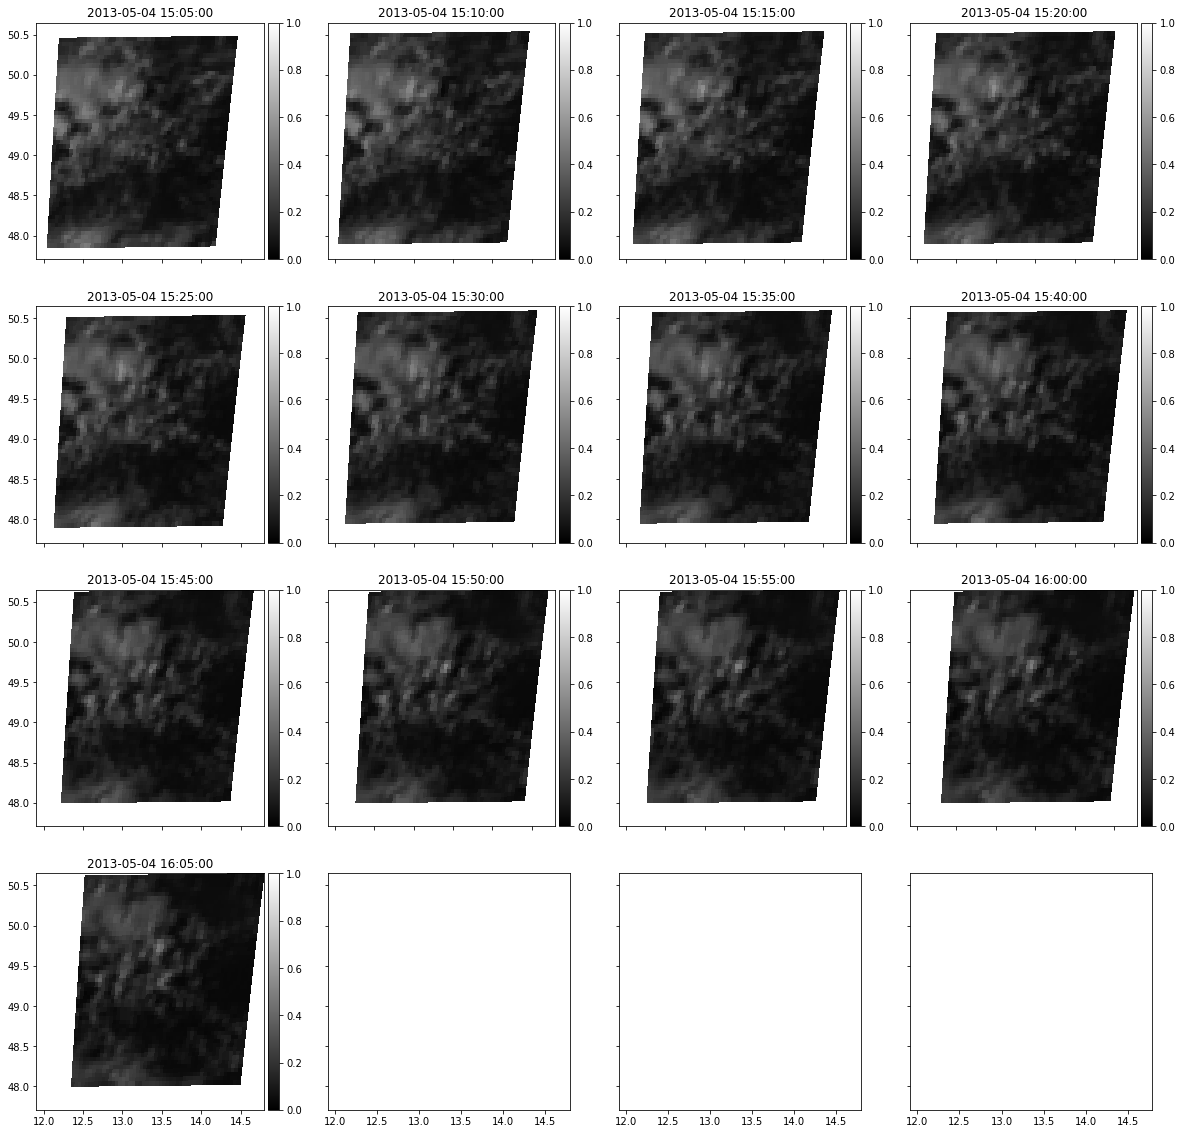

In [18]:
fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
axs = ax.ravel()

for i in range(len(test_case.ir108.data)):
    p = axs[i].pcolormesh(test_case.slon[i],test_case.slat[i],test_case.vis006.data[i],vmin=0,vmax=1,cmap='gray')
    fc.colourbar(p)
    axs[i].set_title(dt.datetime.utcfromtimestamp(test_case.time[i]/1e9))

#### IR&thinsp;12,0&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;10,8&thinsp;µm

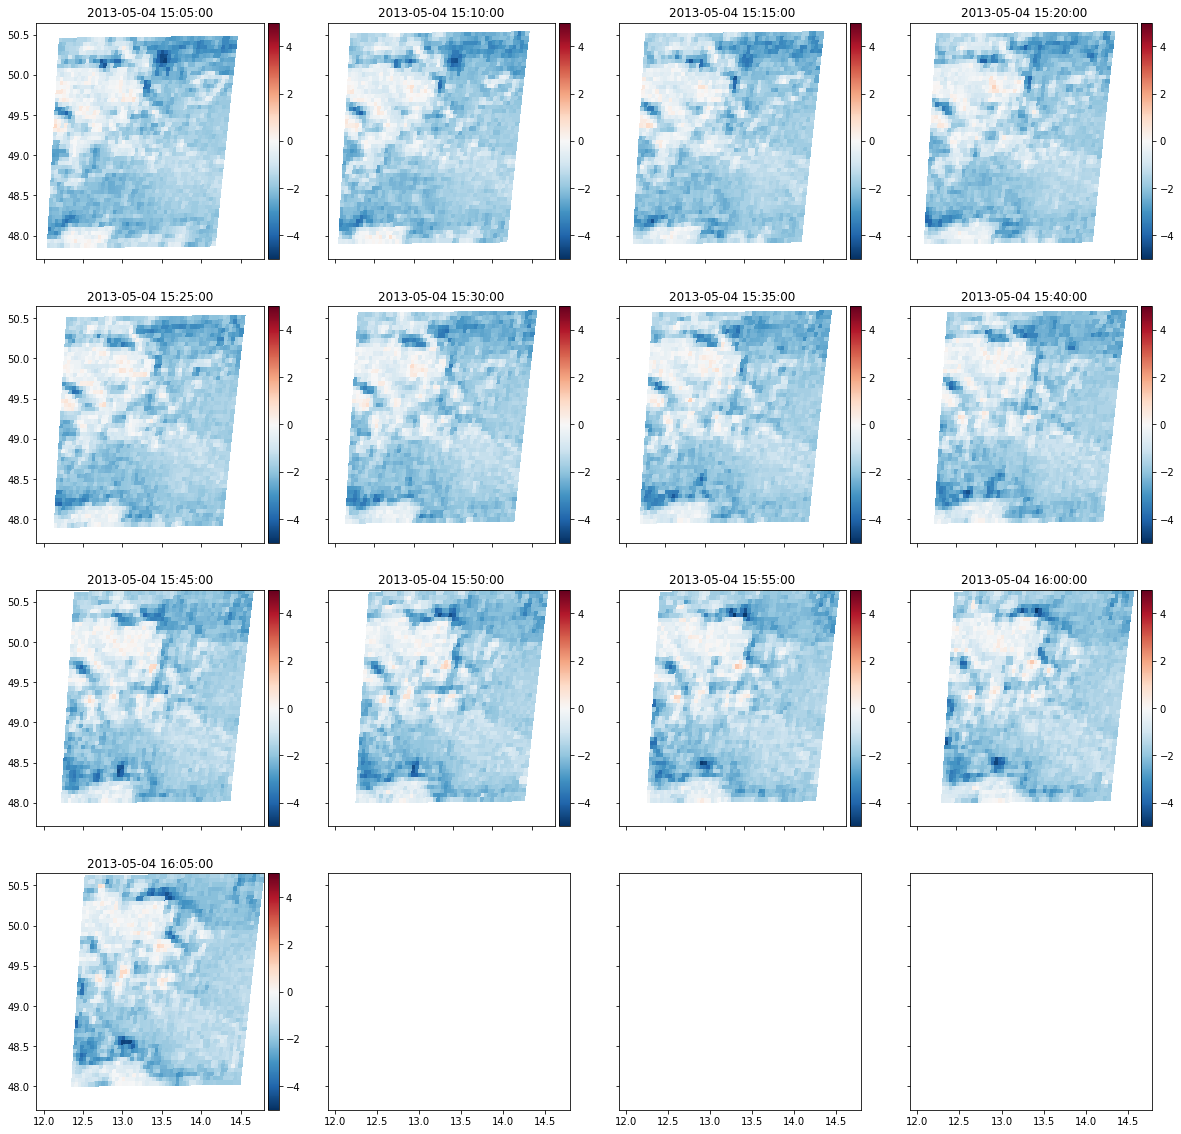

In [19]:
fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
axs = ax.ravel()

for i in range(len(test_case.ir108.data)):
    p = axs[i].pcolormesh(test_case.slon[i],test_case.slat[i],
                          test_case.ir120.data[i]-test_case.ir108.data[i],vmin=-5,vmax=5,cmap='RdBu_r')
    fc.colourbar(p)
    axs[i].set_title(dt.datetime.utcfromtimestamp(test_case.time[i]/1e9))

### Indikatoren für Wolkenphase

#### IR&thinsp;10,8&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;8,7&thinsp;µm

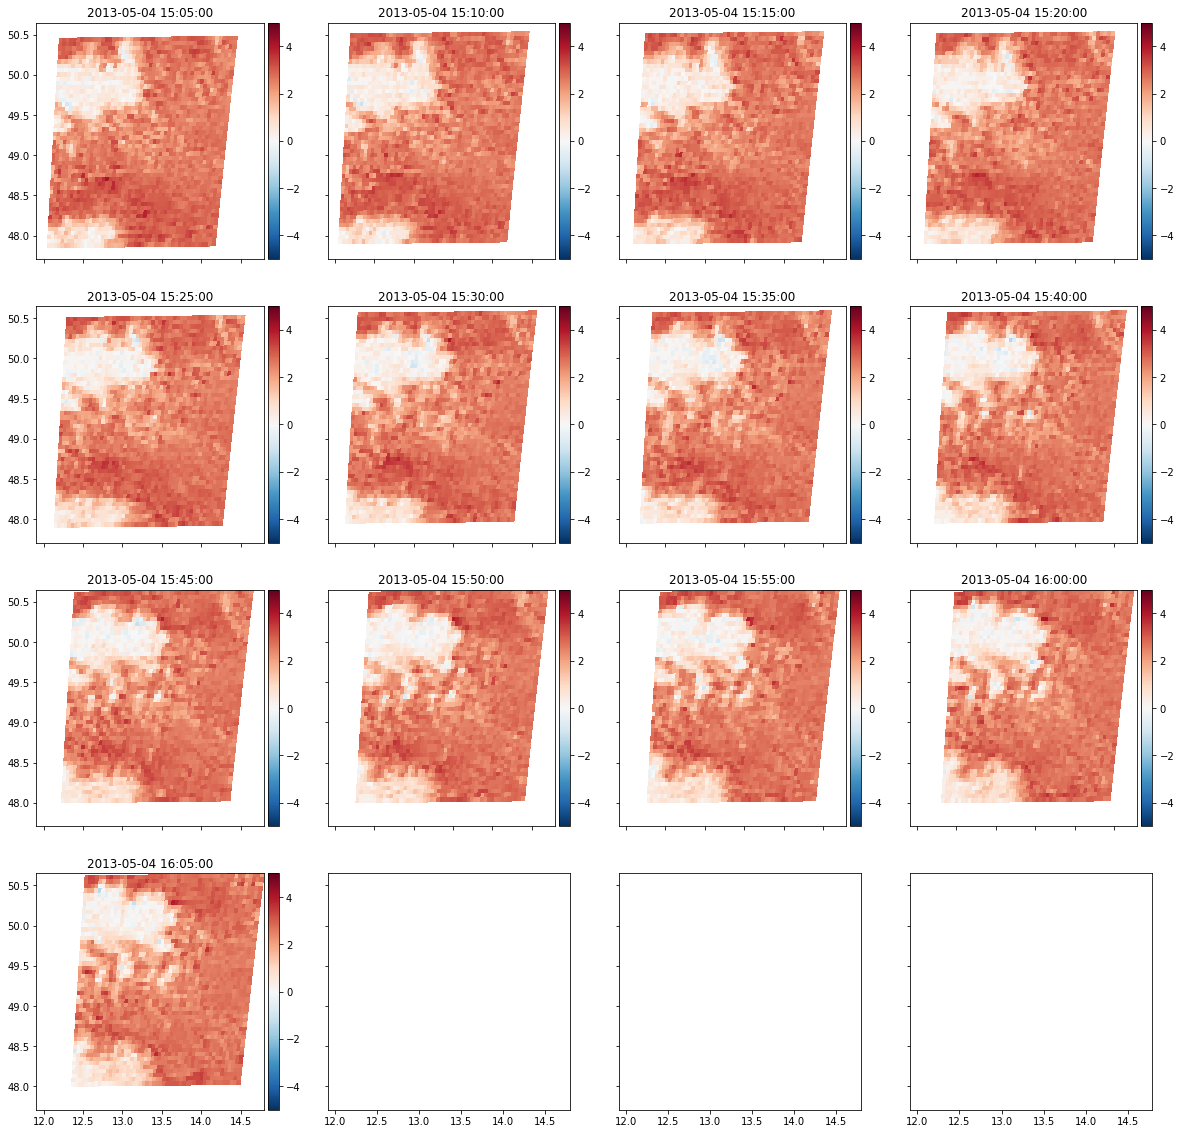

In [20]:
fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
axs = ax.ravel()

for i in range(len(test_case.ir108.data)):
    p = axs[i].pcolormesh(test_case.slon[i],test_case.slat[i],
                          test_case.ir108.data[i]-test_case.ir087.data[i],vmin=-5,vmax=5,cmap='RdBu_r')
    fc.colourbar(p)
    axs[i].set_title(dt.datetime.utcfromtimestamp(test_case.time[i]/1e9))

#### IR&thinsp;10,8&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;3,9&thinsp;µm

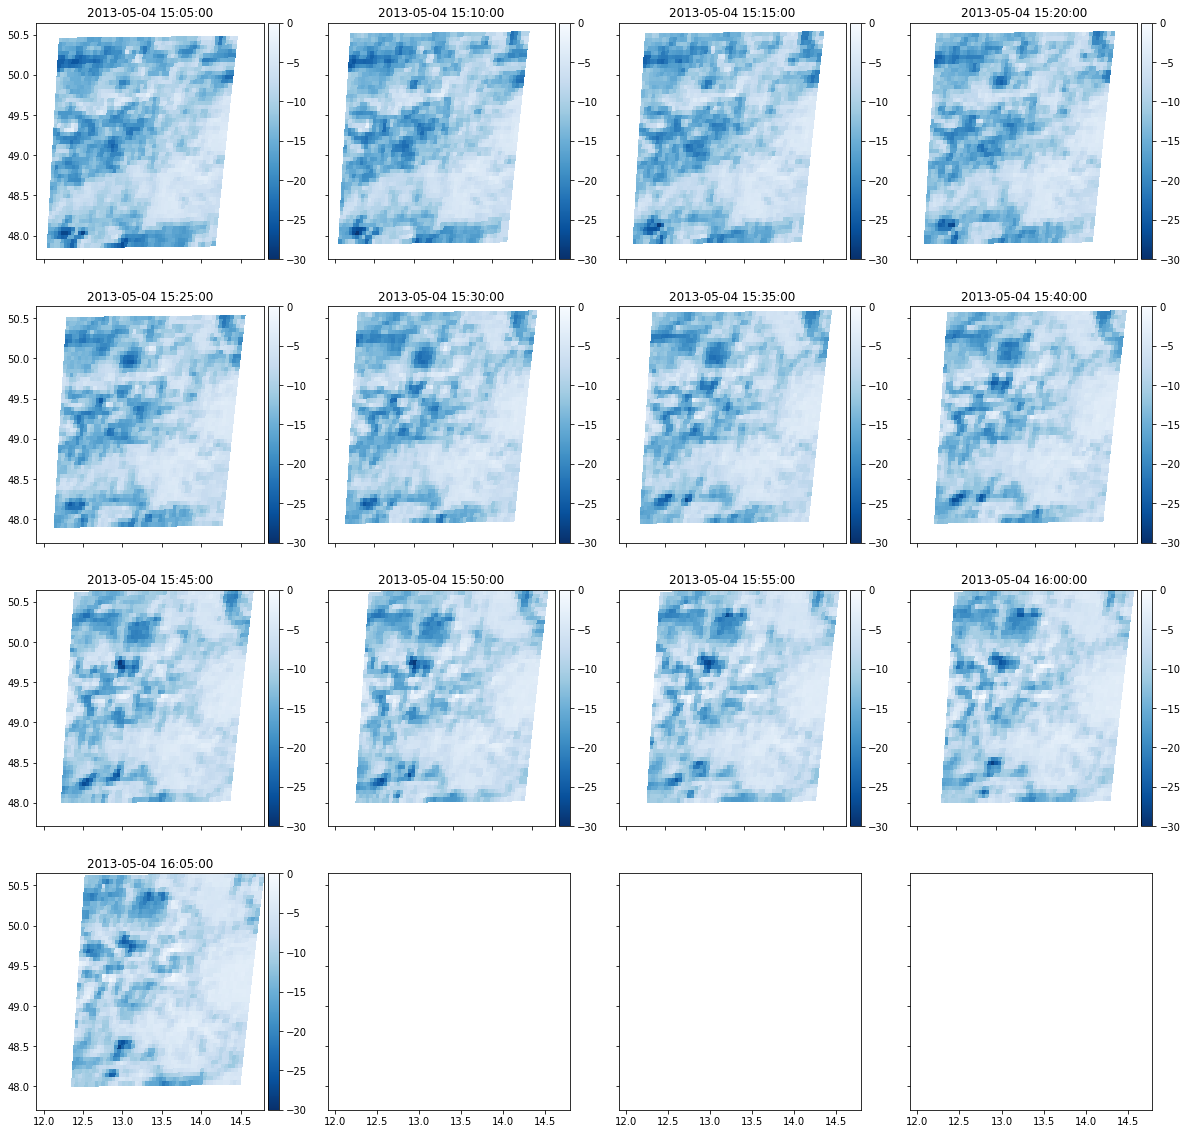

In [21]:
fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
axs = ax.ravel()

for i in range(len(test_case.ir108.data)):
    p = axs[i].pcolormesh(test_case.slon[i],test_case.slat[i],
                          test_case.ir108.data[i]-test_case.ir039.data[i],vmin=-30,vmax=0,cmap='Blues_r')
    fc.colourbar(p)
    axs[i].set_title(dt.datetime.utcfromtimestamp(test_case.time[i]/1e9))

#### IR&thinsp;1,6&thinsp;µm&thinsp;&minus;&thinsp;VIS&thinsp;0,6&thinsp;µm

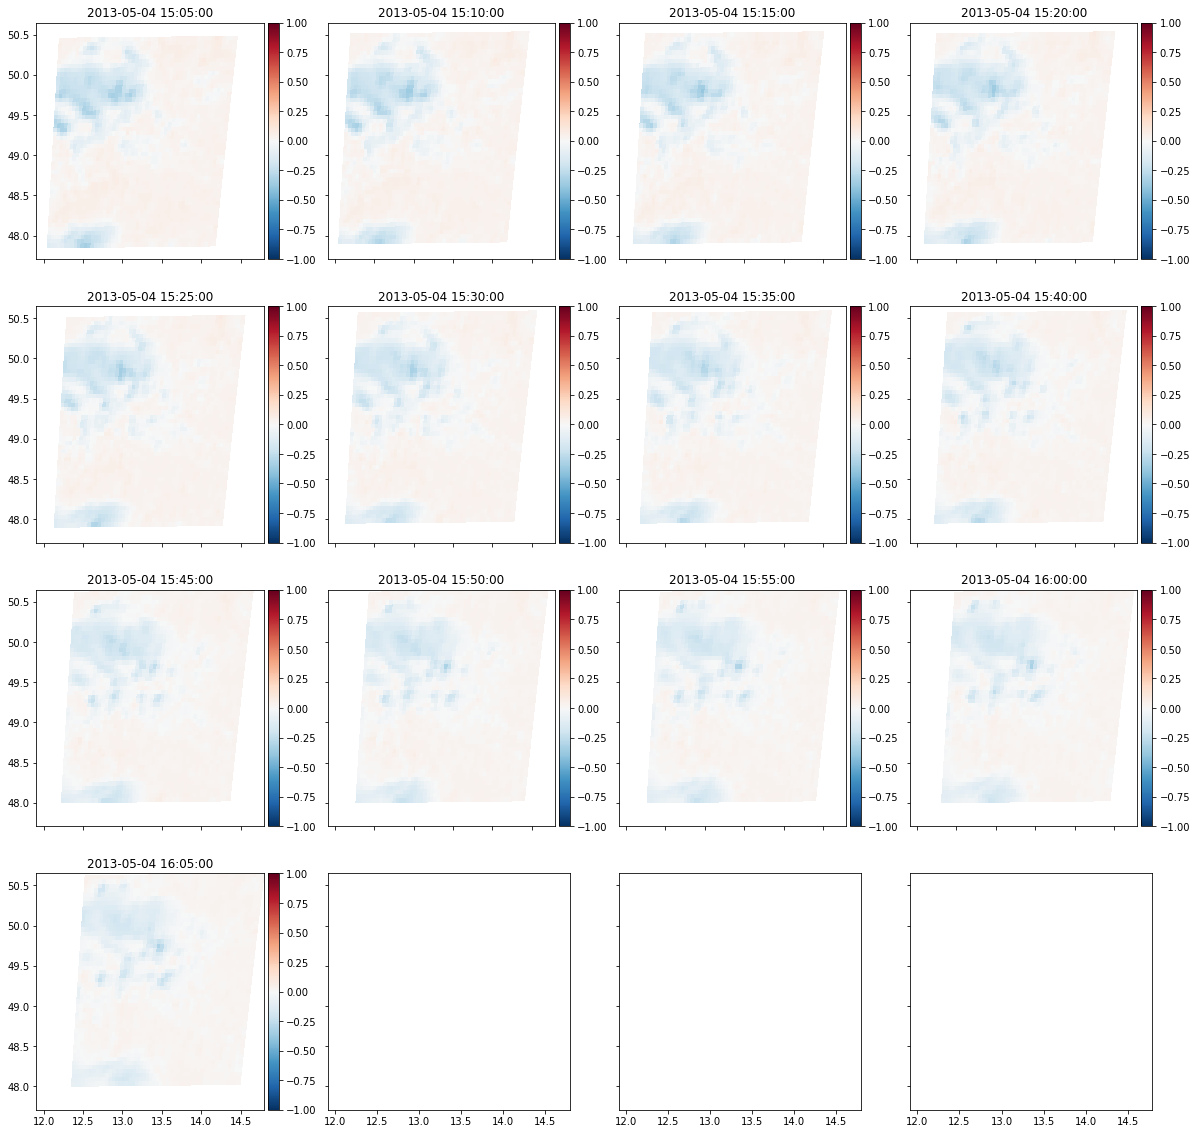

In [22]:
fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
axs = ax.ravel()

for i in range(len(test_case.ir108.data)):
    p = axs[i].pcolormesh(test_case.slon[i],test_case.slat[i],
                          test_case.ir016.data[i]-test_case.vis006.data[i],vmin=-1,vmax=1,cmap='RdBu_r')
    fc.colourbar(p)
    axs[i].set_title(dt.datetime.utcfromtimestamp(test_case.time[i]/1e9))

### Wolkenmikrophysik

#### IR&thinsp;3,9&thinsp;µm-Reflektanz

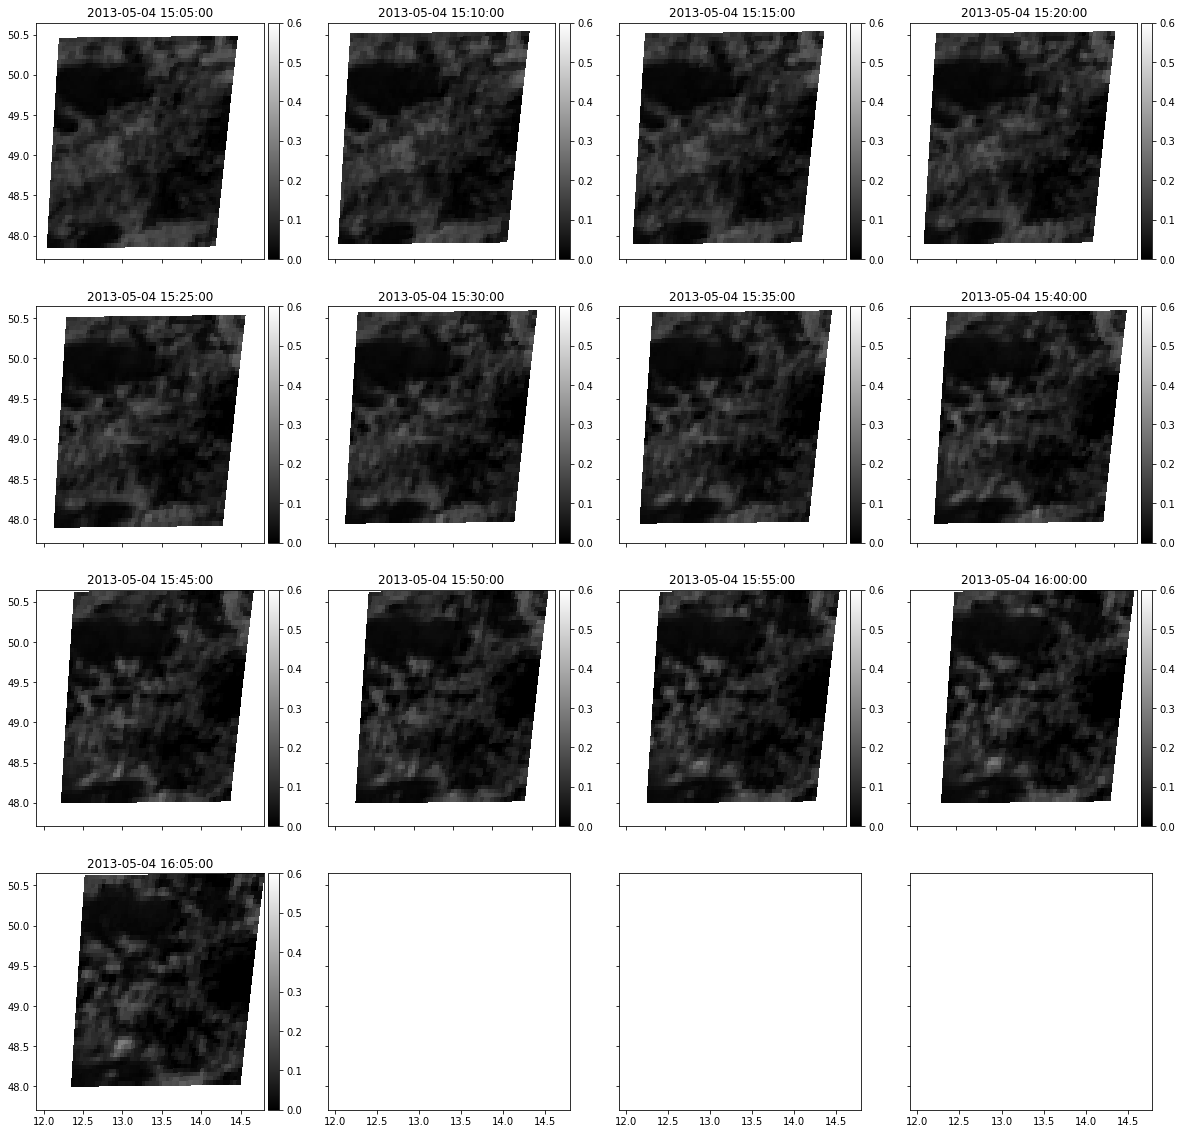

In [23]:
fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
axs = ax.ravel()

for i in range(len(test_case.ir108.data)):
    p = axs[i].pcolormesh(test_case.slon[i],test_case.slat[i],
                          test_case.ref039[i],vmin=0,vmax=0.6,cmap='gray')
                          #ir039_ref_cutout[i],vmin=0,vmax=0.6,cmap='gray')
    fc.colourbar(p)
    axs[i].set_title(dt.datetime.utcfromtimestamp(test_case.time[i]/1e9))

#### IR&thinsp;3,9&thinsp;µm&thinsp;&minus;&thinsp;IR&thinsp;10,8&thinsp;µm

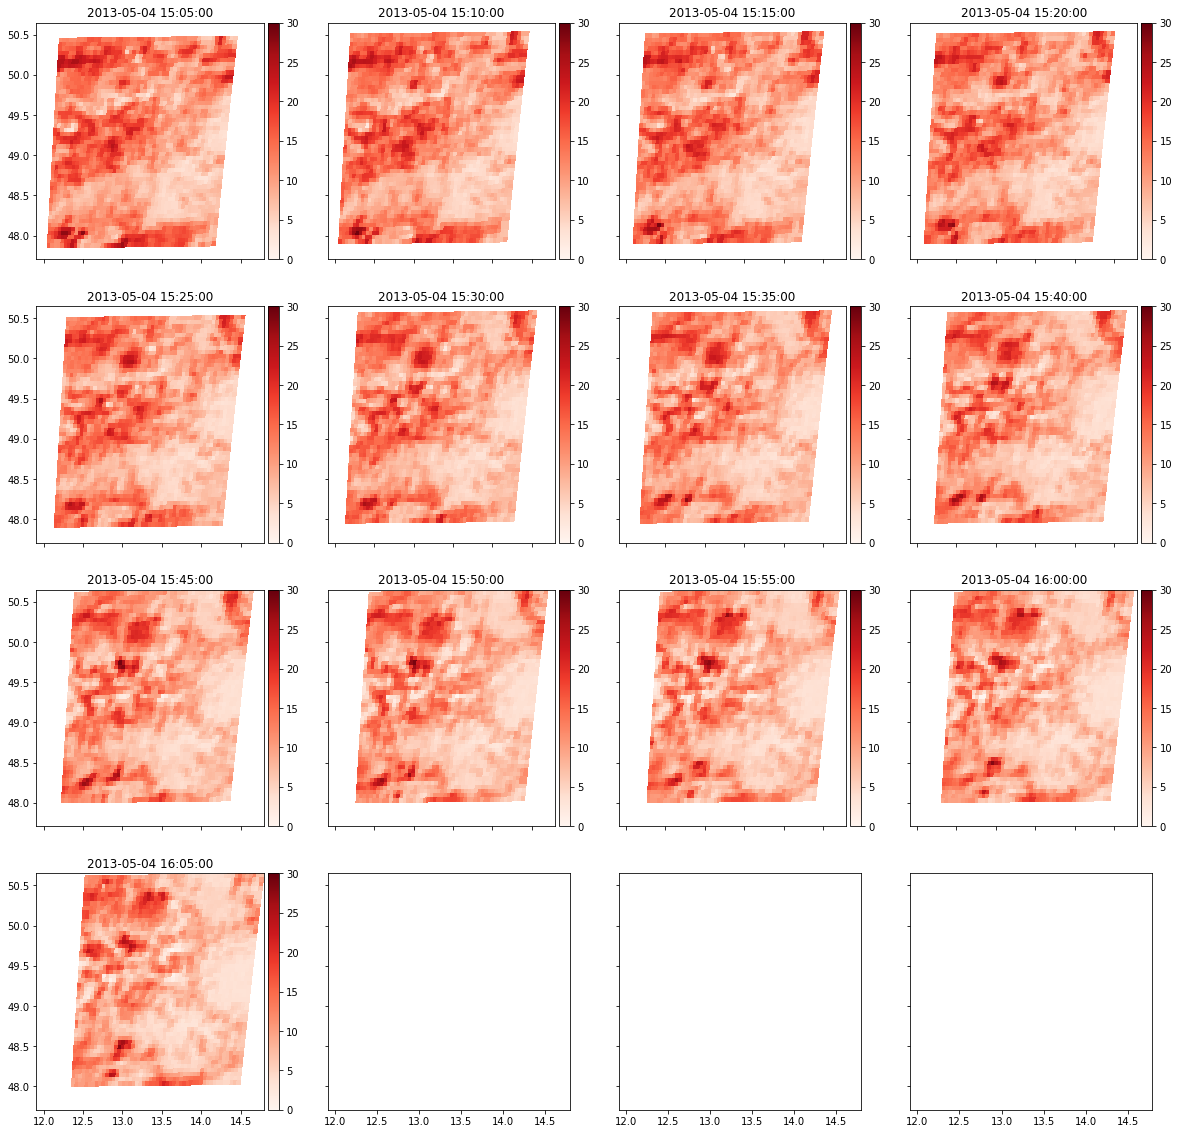

In [25]:
fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
axs = ax.ravel()

for i in range(len(test_case.ir108.data)):
    p = axs[i].pcolormesh(test_case.slon[i],test_case.slat[i],
                          test_case.ir039.data[i]-test_case.ir108.data[i],vmin=0,vmax=30,cmap='Reds')
    fc.colourbar(p)
    axs[i].set_title(dt.datetime.utcfromtimestamp(test_case.time[i]/1e9))

#### IR&thinsp;10,8&thinsp;µm

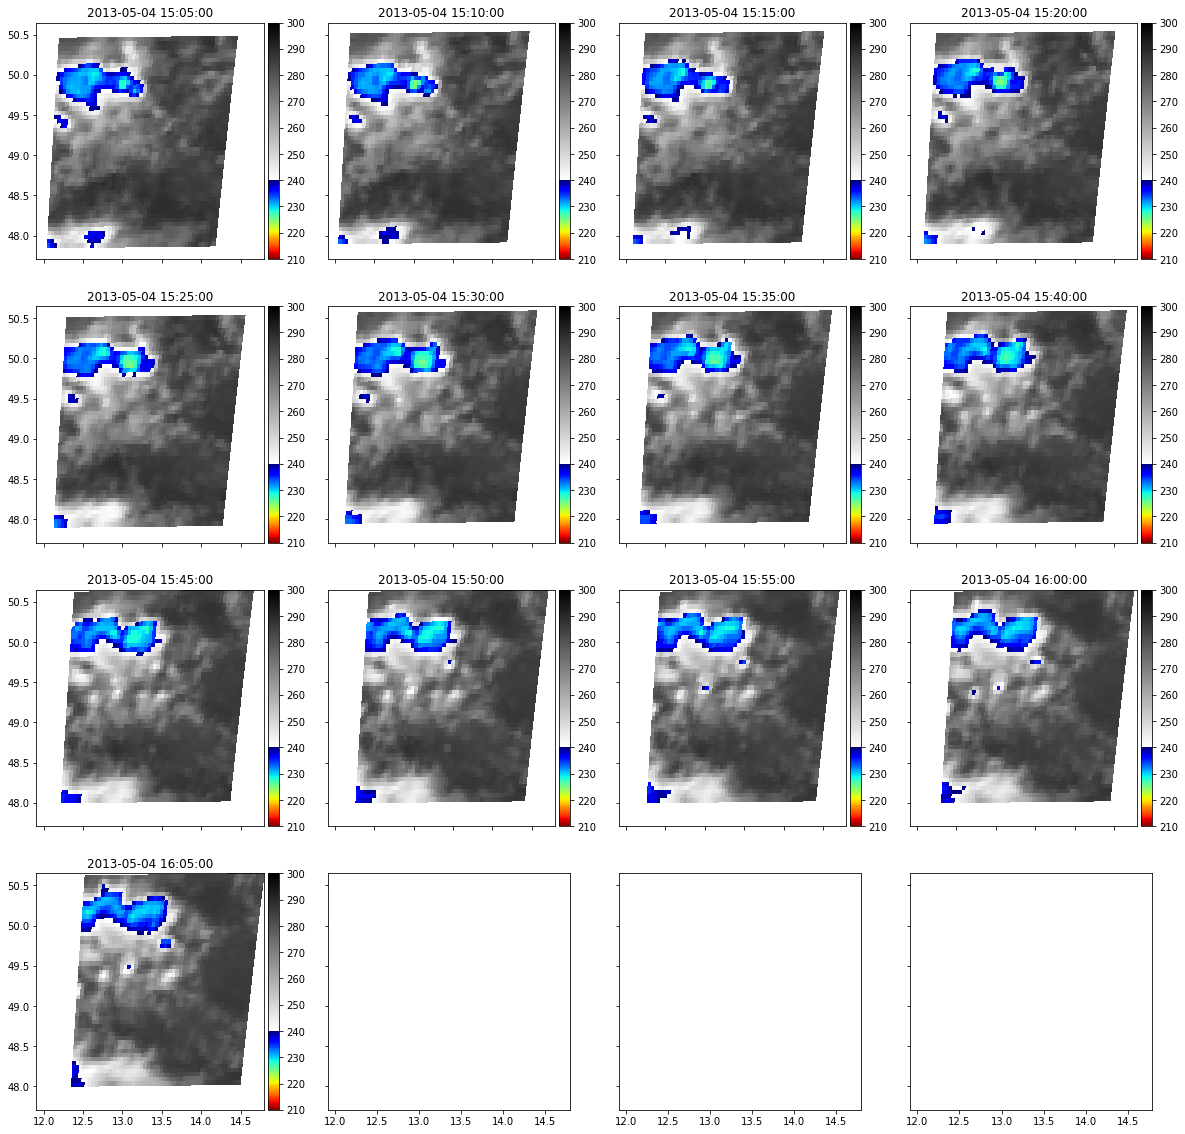

In [26]:
fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
axs = ax.ravel()

for i in range(len(test_case.ir108.data)):
    p = axs[i].pcolormesh(test_case.slon[i],test_case.slat[i],
                          test_case.ir108.data[i],vmin=210,vmax=300,cmap=emap)
    fc.colourbar(p)
    axs[i].set_title(dt.datetime.utcfromtimestamp(test_case.time[i]/1e9))

### Severe Strorms RGB zum Vergleich

In [28]:
crgb = [conv_rgb(test_case.vis006.data[i],
                 test_case.ir016.data[i],
                 test_case.ir039.data[i],
                 test_case.wv062.data[i],
                 test_case.wv073.data[i],
                 test_case.ir108.data[i]) for i in range(len(test_case.ir108.data))]

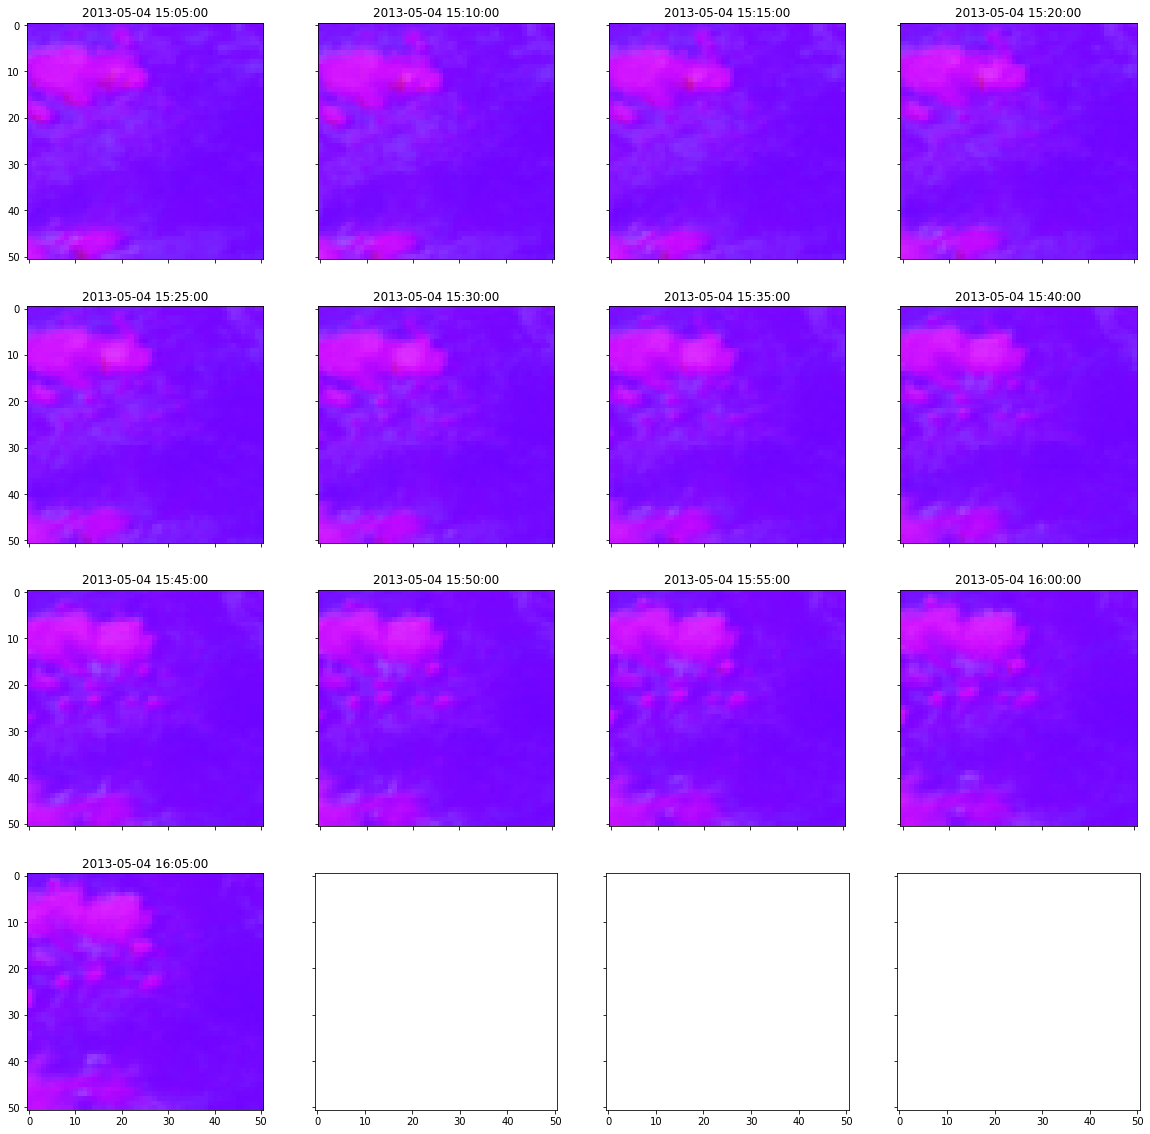

In [29]:
fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
axs = ax.ravel()

for i in range(len(crgb)):
    axs[i].imshow(crgb[i])
    axs[i].set_title(dt.datetime.utcfromtimestamp(test_case.time[i]/1e9))

In [30]:
mprgb = [day_microphysics_rgb(test_case.vis008.data[i],
                              test_case.ref039.data[i],
                              test_case.ir108.data[i]) for i in range(len(test_case.ir108.data))]

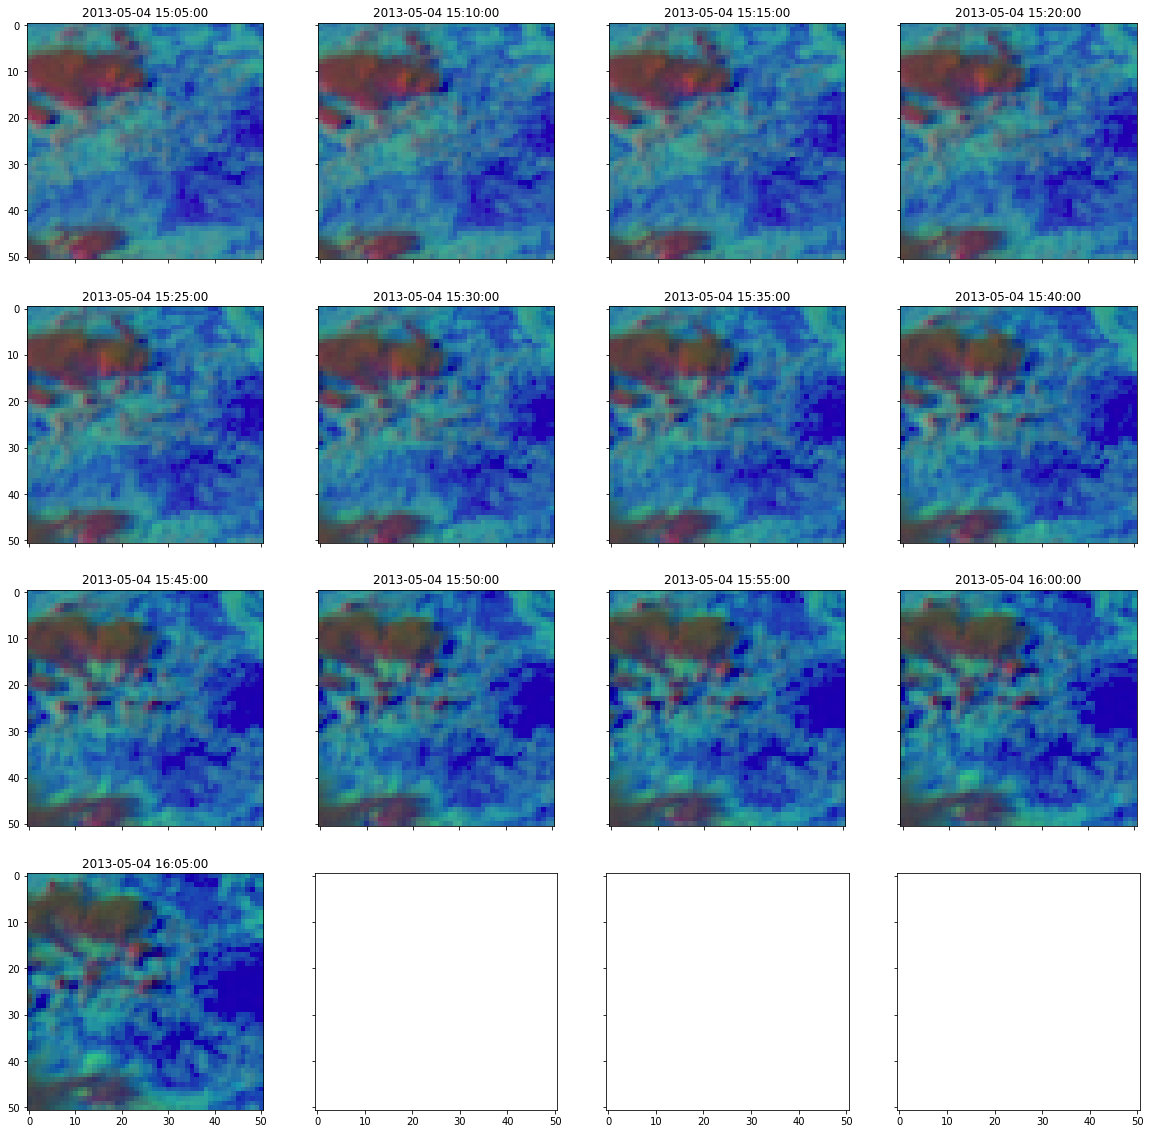

In [31]:
fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
axs = ax.ravel()

for i in range(len(mprgb)):
    axs[i].imshow(mprgb[i])
    axs[i].set_title(dt.datetime.utcfromtimestamp(test_case.time[i]/1e9))

In [39]:
from scipy import ndimage as ndi

In [41]:
DWV = test_case.wv062 - test_case.wv073
DIR = test_case.ir039 - test_case.ir108
DVIS = test_case.ir016 - test_case.vis006

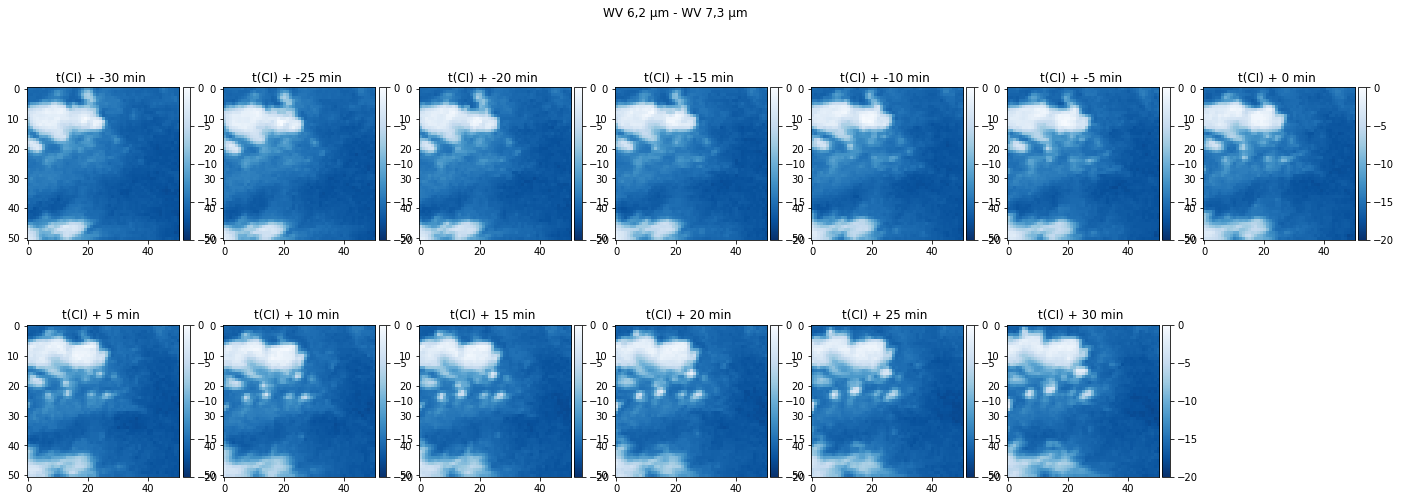

In [42]:
fig,ax = plt.subplots(2,7,figsize=(24,8))
axs = ax.ravel()

for i,d in enumerate(DWV):
    p = axs[i].imshow(d,vmin=-20,vmax=0,cmap='Blues_r')
    fc.colourbar(p)
    axs[i].set_title("t(CI) + {} min ".format(i*5-30))
plt.suptitle("WV 6,2 µm - WV 7,3 µm")    
fig.delaxes(axs[-1]) 
plt.savefig("bilder/DWV_beispiel.png")

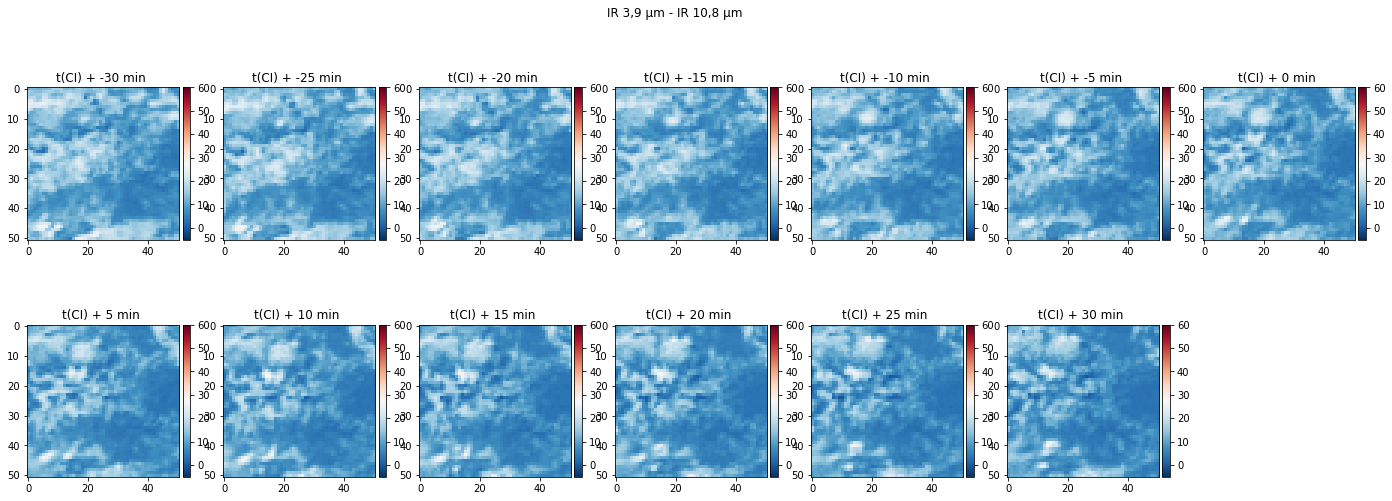

In [43]:
fig,ax = plt.subplots(2,7,figsize=(24,8))
axs = ax.ravel()

for i,d in enumerate(DIR):
    p = axs[i].imshow(d,vmin=-5,vmax=60,cmap='RdBu_r')
    fc.colourbar(p)
    axs[i].set_title("t(CI) + {} min ".format(i*5-30))
plt.suptitle("IR 3,9 µm - IR 10,8 µm")
fig.delaxes(axs[-1]) 
plt.savefig("bilder/DIR_beispiel.png")

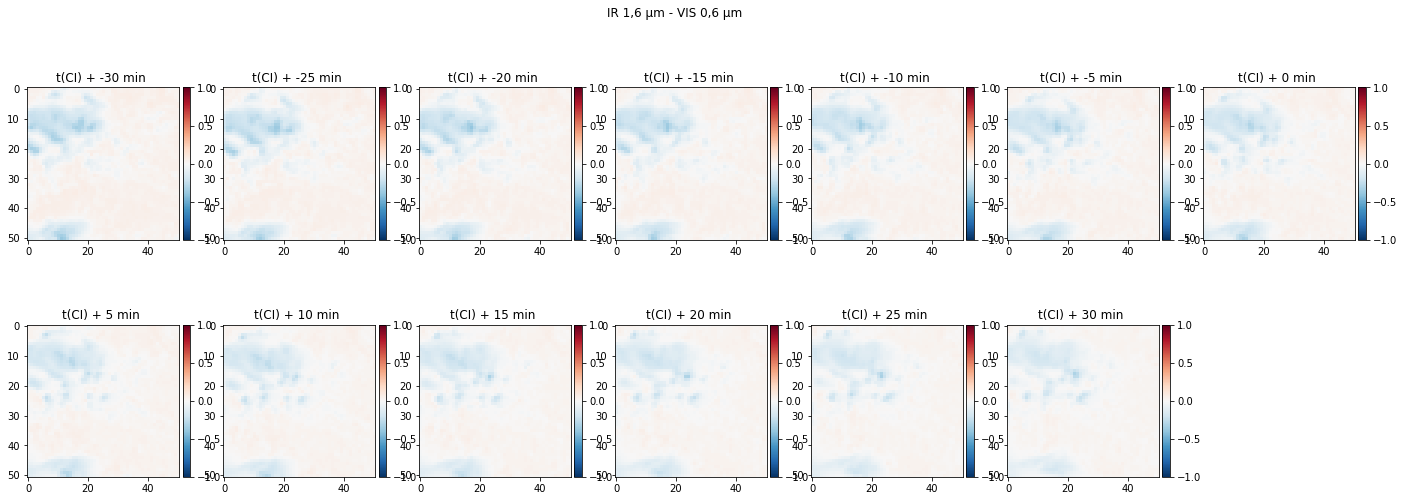

In [44]:
fig,ax = plt.subplots(2,7,figsize=(24,8))
axs = ax.ravel()

for i,d in enumerate(DVIS):
    p = axs[i].imshow(d,vmin=-1,vmax=1,cmap='RdBu_r')
    fc.colourbar(p)
    axs[i].set_title("t(CI) + {} min ".format(i*5-30))

plt.suptitle("IR 1,6 µm - VIS 0,6 µm")
fig.delaxes(axs[-1]) 
plt.savefig("bilder/DVIS_beispiel.png")

In [54]:
def get_multispectral_object(vis006,ir016,ir039,wv062,wv073,ir108,DWV_thresh=-10,DIR_thresh=20, DVIS_thresh=0.05,dilation=True):
    DWV = wv062 - wv073
    DIR = ir039 - ir108
    DVIS = ir016 - vis006 
    
    DWV_mask = np.ma.masked_less(DWV,DWV_thresh)
    DIR_mask = np.ma.masked_greater(DIR,DIR_thresh)
    DVIS_mask = np.ma.masked_greater(DVIS,DVIS_thresh)
    
    mask = ~DWV_mask.mask & ~DIR_mask.mask & ~DVIS_mask.mask
    
    if dilation:
        return ndi.binary_dilation(mask)
    else:
        return mask

In [55]:
import sys
sys.path.append("/vols/satellite/home/lenk/proj/2018-05_cieval/python/filtered_graph_branch/")
import cieval_tools as ct
import networkx as nx
from scipy import ndimage as ndi

In [116]:
test_case_clusters = get_multispectral_object(test_case.vis006.data,
                                              test_case.ir016.data,
                                              test_case.ir039.data,
                                              test_case.wv062.data,
                                              test_case.wv073.data,
                                              test_case.ir108.data)

In [117]:
clusters = [ndi.label(m)[0] for m in test_case_clusters]

In [58]:
import sys
sys.path.append("{}/utils/tracking".format(local_home_path))
import object_tracking as ot
from importlib import reload

In [41]:
reload(ot)

<module 'object_tracking' from '/vols/satellite/home/lenk/utils/tracking/object_tracking.py'>

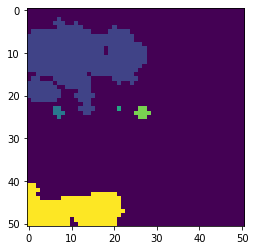

In [118]:
plt.imshow(clusters[6])

In [119]:
connections, objects = ot.generate_graph_from_components(clusters,
                                                         np.arange(0,len(test_case_clusters),1))

In [120]:
wanted_id = ot.get_wanted_object_id(clusters)
target_object_id = '{}_{:04d}'.format(len(clusters)//2,wanted_id)

In [121]:
wanted_id

4

In [122]:
wanted_object_graph = ot.get_wanted_graph(objects,target_object_id)

In [123]:
wanted_object_graph

In [124]:
wanted_object_graph_sorted = ot.sort_graph_by_timesteps(wanted_object_graph)

In [125]:
wanted_object_graph_sorted

{11: ['11_0006', '11_0007'],
 6: ['6_0003', '6_0004'],
 7: ['7_0005', '7_0004'],
 5: ['5_0005'],
 9: ['9_0005', '9_0004'],
 8: ['8_0004', '8_0005'],
 4: ['4_0002'],
 10: ['10_0002', '10_0004'],
 12: ['12_0006', '12_0005']}

In [126]:
object_track = ot.get_main_track(clusters,wanted_object_graph_sorted,target_object_id)

In [127]:
wanted_object = ot.get_wanted_objects(clusters,object_track)

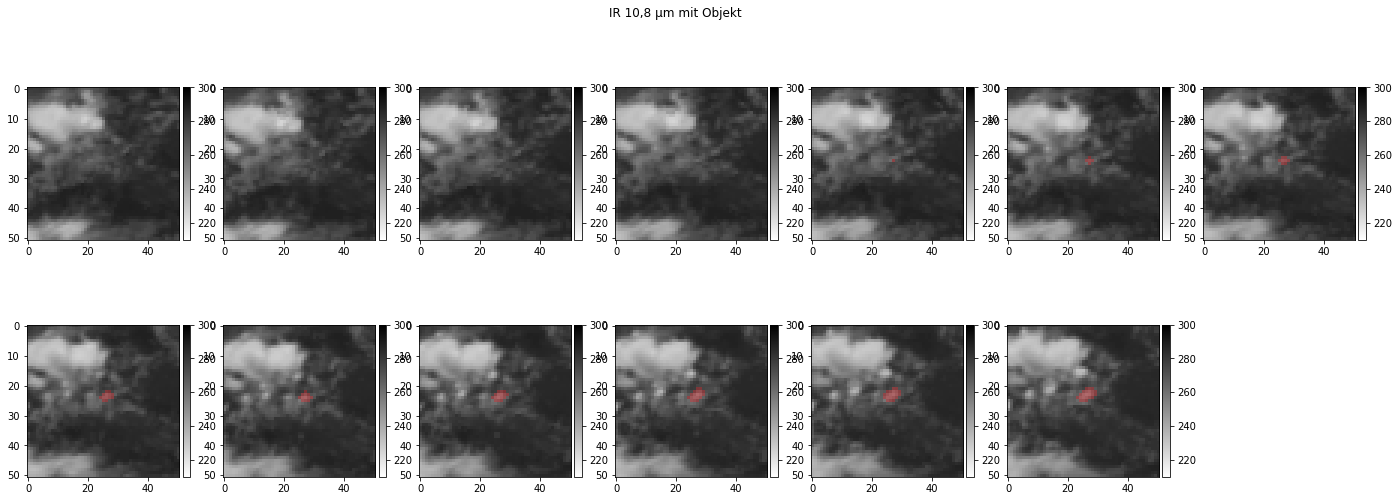

In [128]:
fig,ax = plt.subplots(2,7,figsize=(24,8))
axs = ax.ravel()

for i, w in enumerate(wanted_object):
    p = axs[i].imshow(test_case.ir108.data[i],vmin=210,vmax=300,cmap='gray_r')
    fc.colourbar(p)
    axs[i].imshow(np.ma.masked_less(w,1),alpha=0.4,cmap='Reds',vmin=0,vmax=1.3)
    #axs[i].set_title("t(CI) + {} min ".format(i*5-30))

plt.suptitle("IR 10,8 µm mit Objekt")
fig.delaxes(axs[-1]) 
plt.savefig("bilder/objekt_beispiel.png")

In [70]:
values = {k:[] for k in test_case.data_vars}

for i in range(len(test_case.ir108.data)):
    for k in test_case.data_vars:
        if k in ['rx','flash_density','mean_current','max_current']:
            continue
        else:
            point_idx = np.where(wanted_object[i]==1)
            values[k].append(test_case[k].data[i][point_idx])

In [71]:
mean_ctth = [np.mean(values['ctth'][i]) for i in range(13)]

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [72]:
mean_ctth

[nan,
 nan,
 nan,
 nan,
 2200.0,
 2440.0,
 3125.0,
 3892.3076923076924,
 3416.6666666666665,
 3912.5,
 3978.9473684210525,
 3580.9523809523807,
 3452.1739130434785]

In [73]:
ctype = [np.unique(values['ct'][i],return_counts=True) for i in range(13)]

In [74]:
ctype

[(array([], dtype=float64), array([], dtype=int64)),
 (array([], dtype=float64), array([], dtype=int64)),
 (array([], dtype=float64), array([], dtype=int64)),
 (array([], dtype=float64), array([], dtype=int64)),
 (array([8.]), array([1])),
 (array([ 8., 10.]), array([4, 1])),
 (array([ 6.,  8., 10., 15.]), array([1, 5, 1, 1])),
 (array([ 6.,  8., 10., 15.]), array([1, 6, 4, 2])),
 (array([ 8., 10., 12., 19.]), array([5, 5, 1, 1])),
 (array([ 8., 10., 12., 16., 19.]), array([5, 8, 1, 1, 1])),
 (array([ 8., 10., 12., 19.]), array([ 6, 11,  1,  1])),
 (array([ 8., 10., 12., 19.]), array([ 6, 11,  1,  3])),
 (array([ 1.,  8., 10., 12., 19.]), array([1, 7, 9, 3, 3]))]

Das scheint soweit zu als Objektdefinition zu funktionieren. Dann versuchen wir das doch nochmal mit einem anderen Fall.

In [85]:
def extract_wanted_object(clusters):
     # connect the objects of all time steps
    cconnections, objects = ot.generate_graph_from_components(clusters,
                                                              np.arange(0,len(clusters),1))

    # determine the interesting object, it should be in the centre of the 
    # centre time step
    wanted_id = ot.get_wanted_object_id(clusters)
    target_object_id = '{}_{:04d}'.format(len(clusters)//2,wanted_id)

    # look for the graph wich cointains this object
    wanted_object_graph = ot.get_wanted_graph(objects,target_object_id)

    # it may be that this is a complex graph, but ideally we only want the
    # path of a single cell
    wanted_object_graph_sorted = ot.sort_graph_by_timesteps(wanted_object_graph)

    object_track = ot.get_main_track(clusters,wanted_object_graph_sorted,target_object_id)

    # get the objects
    wanted_object = ot.get_wanted_objects(clusters,object_track)
    
    return wanted_object

In [433]:
def get_multispectral_object(vis006,ir016,ir039,wv062,wv073,ir108,DWV_thresh=-10,DIR_thresh=20, DVIS_thresh=0.05,dilation=True):
    DWV = wv062 - wv073
    DIR = ir039 - ir108
    DVIS = ir016 - vis006 
    
    DWV_mask = np.ma.masked_less(DWV,DWV_thresh)
    DIR_mask = np.ma.masked_greater(DIR,DIR_thresh)
    DVIS_mask = np.ma.masked_greater(DVIS,DVIS_thresh)
    
    mask = ~DWV_mask.mask & ~DIR_mask.mask & ~DVIS_mask.mask
    
    if dilation:
        return ndi.binary_dilation(mask)
    else:
        return mask

Das funktioniert auch recht gut. Die Segmentierung läuft analog dem Severe Storms RGB folgendermaßen ab:

1. Trackdaten laden
2. IR&thinsp;3,9&thinsp;µm-Kanal für CO<sub>2</sub>-Absorption korrigieren
3. drei Kanaldifferenzen berechnen:
    - &Delta;<i>T</i><sub>B</sub>(6,2&thinsp;µm, 7,3&thinsp;µm)
    - &Delta;<i>T</i><sub>B</sub>(3,9&thinsp;µm, 10,8&thinsp;µm)
    - &Delta;BDRF(1,6&thinsp;µm, 0,6&thinsp;µm)   
4. multispektrale Segmentierung mit drei Schwellwerten, Objektdefinition mit:
    - &Delta;<i>T</i><sub>B</sub>(6,2&thinsp;µm, 7,3&thinsp;µm)&thinsp;<&thinsp;-10&thinsp;K
    - &Delta;<i>T</i><sub>B</sub>(3,9&thinsp;µm, 10,8&thinsp;µm)&thinsp;>&thinsp;20&thinsp;K
    - &Delta;BDRF(1,6&thinsp;µm, 0,6&thinsp;µm)&thinsp;>&thinsp;0,05
5. Dann wir das Objekt ausfgewählt, das zum CI-Zeitpunkt am nächstem am Mittelpunkt des Ausschnittes ist und über die Zeit verfolgt.


Allerdings funtioniert das nur bei Tag, weil wir von Daten im sichtbaren Spektrum abhängig sind. Eventuell lässt sich die trispektrale Differenz aus IR&thinsp;8,7&thinsp;µm-, IT&thinsp;10,8&thinsp;µm- und IR&thinsp;12,0&thinsp;µm-Kanal einsetzten, um die Eisinformation anzuleiten.

## Multispektrale Objektdenfinition nur mit IR-Kanälen

Es werden wieder drei Kanaldifferenten berechnet:
- &Delta;<i>T</i><sub>B</sub>(6,2&thinsp;µm; 7,3&thinsp;µm)&thinsp;<&thinsp;-20&thinsp;K
- &Delta;<i>T</i><sub>B</sub>(3,9&thinsp;µm; 10,8&thinsp;µm)&thinsp;<&thinsp;7&thinsp;K
- &Delta;<i>T</i><sub>B</sub>(8,7&thinsp;µm; 10,8&thinsp;µm; 12,0&thinsp;µm)&thinsp;<&thinsp;-4&thinsp;K   


In [143]:
def get_multispectral_object2(ir039,wv062,wv073,ir087,ir108,ir120,
                              DWV_thresh=-20,DIR1_thresh=7, DIR2_thresh=-4,dilation=True):
    DWV = wv062 - wv073
    DIR1 = ir039 - ir108
    DIR2 = (ir087 - ir108) - (ir108 - ir120)
    
    DWV_mask = np.ma.masked_greater(DWV,DWV_thresh)
    DIR1_mask = np.ma.masked_greater(DIR1,DIR1_thresh)
    DIR2_mask = np.ma.masked_greater(DIR2,DIR2_thresh)
    
    mask = DWV_mask.mask & DIR1_mask.mask & DIR2_mask.mask

    if dilation:
        return ndi.binary_dilation(mask)
    else:
        return mask

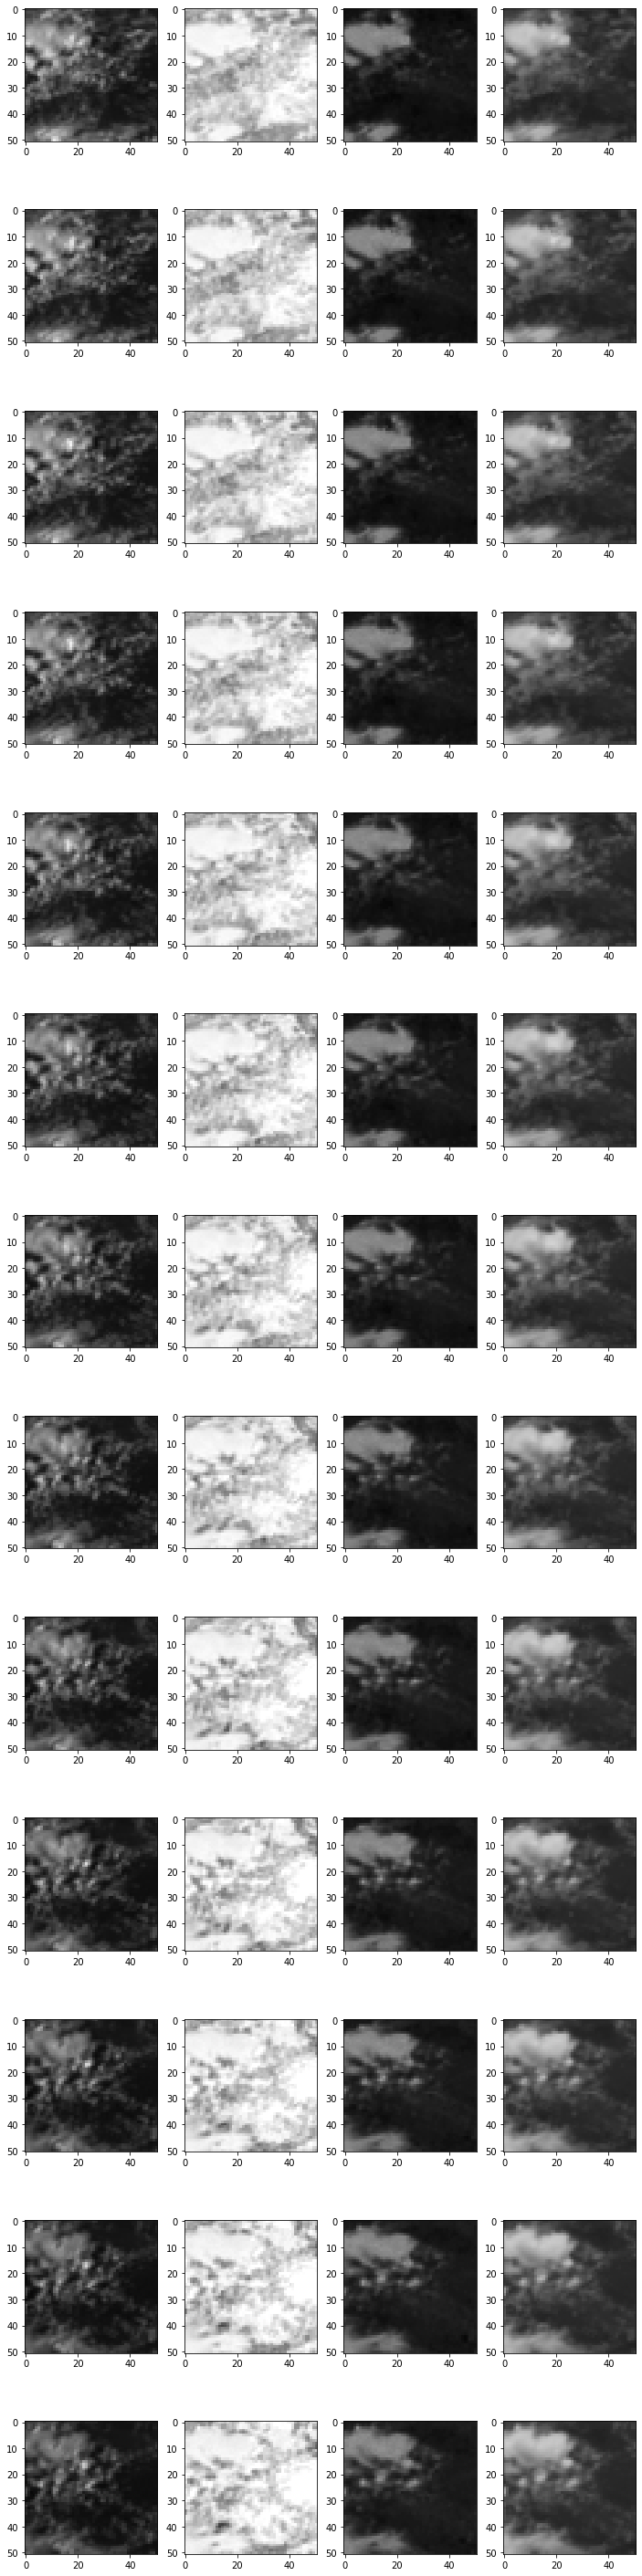

In [175]:
fig,ax = plt.subplots(13,4,figsize=(4*3,4*13))

for i, d in enumerate(test_case.ir108.data):
    ax[i,0].imshow(test_case.vis006.data[i],vmin=0,vmax=0.6,cmap='gray')
    ax[i,1].imshow(test_case.ref039.data[i],vmin=0,vmax=0.4,cmap='gray_r')
    ax[i,2].imshow(test_case.ir039.data[i],vmin=200,vmax=300,cmap='gray_r')
    ax[i,3].imshow(d,vmin=210,vmax=300,cmap='gray_r')

In [228]:
test_case_clusters2 = get_multispectral_object2(test_case.ir039.data,
                                                test_case.wv062.data,
                                                test_case.wv073.data,
                                                test_case.ir087.data,
                                                test_case.ir108.data,
                                                test_case.ir120.data,
                                                -18,15,-4,
                                                dilation=False)

In [229]:
clusters2 = [ndi.label(t)[0] for t in test_case_clusters2]

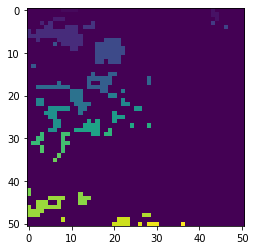

In [230]:
plt.imshow(clusters2[6])

In [231]:
wanted_object2 = extract_wanted_object(clusters2)

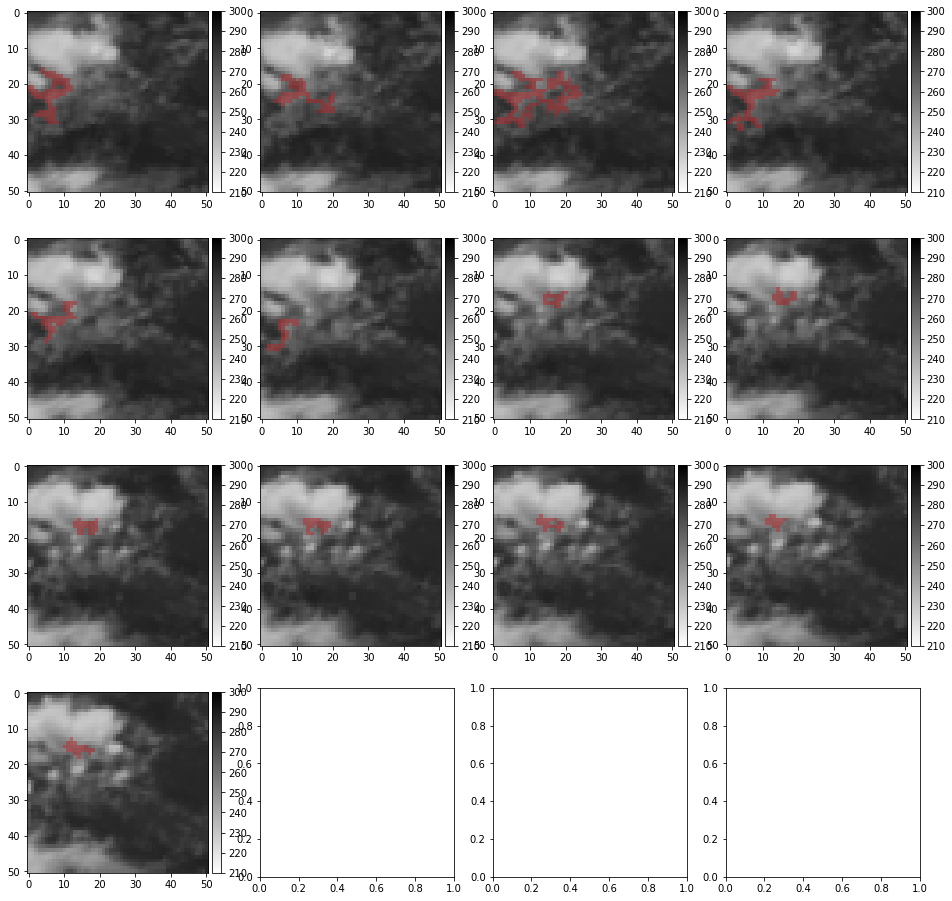

In [232]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i, w in enumerate(wanted_object2):
    p = axs[i].imshow(test_case.ir108.data[i],vmin=210,vmax=300,cmap='gray_r')
    fc.colourbar(p)
    axs[i].imshow(np.ma.masked_less(w,1),alpha=0.4,cmap='Reds',vmin=0,vmax=1.3)
    #axs[i].imshow(np.ma.masked_less(wanted_object[i],1),alpha=0.4,cmap='Blues',vmin=0,vmax=1.3)

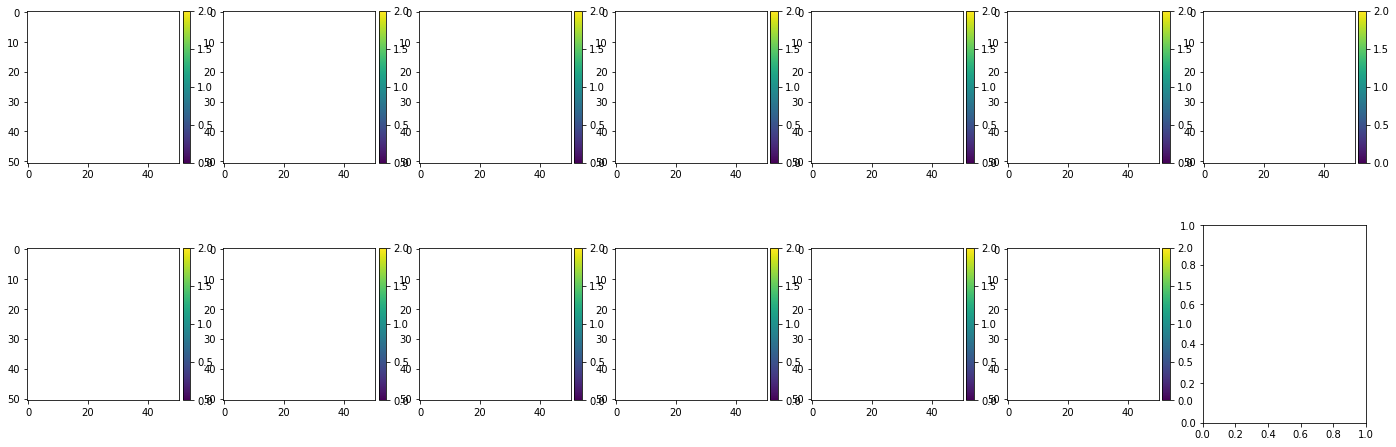

In [200]:
fig,ax = plt.subplots(2,7,figsize=(24,8))
axs = ax.ravel()

for i, w in enumerate(wanted_object2):
    p = axs[i].imshow(np.ma.masked_less(w,1) + np.ma.masked_less(wanted_object[i],1),vmin=0,vmax=2)
    fc.colourbar(p)    

Die beiden Ansätze scheinen hier äquivalent zu sein. Dann benutzen wir am besten den Ansatz, der nur auf den IR-Kanälen basiert, weil wir damit auch Fälle in der Nacht erfassen können.

## Für alle Fälle 2013

In [497]:
haci_cases_classified = pd.read_csv("{}/2019-01_trackingstudie/HACI_cases_manually_classified.csv".format(proj_path))

In [496]:
values = {k:[] for k in list(test_case.data_vars)[:15] + ['case_id','time_idx','class']}

In [498]:
for tr in track_files:
    try:
        track_data = xr.open_dataset(tr)

        track_id = "{}_{}".format(tr.split("/")[-1].split(".")[0].split("_")[-2],
                                  tr.split("/")[-1].split(".")[0].split("_")[-1])
        
        print("\n{}\n".format(track_id))

        track_class = haci_cases_classified[haci_cases_classified.case_id == track_id].Klasse

        track = pd.read_csv("{}/track_{}.csv".format(track_path,track_id))

        ir039_ref, ir039 = corrected_ir039_cutout(track_data,track,51)

        track_clusters = get_multispectral_object(track_data.vis006.data,
                                                  track_data.ir016.data,
                                                  ir039,
                                                  track_data.wv062.data,
                                                  track_data.wv073.data,
                                                  track_data.ir108.data)

        clusters = [ndi.label(m)[0] for m in track_clusters]
        wanted_object = extract_wanted_object(clusters)

        for i in range(len(clusters)):
            t_idx = i*5  - 30
            value_idx = np.where(wanted_object[i]==1)

            values['time_idx'].extend([t_idx]*len(value_idx[0]))
            values['case_id'].extend([track_id]*len(value_idx[0]))
            values['class'].extend([track_class]*len(value_idx[0]))

            for k in list(track_data.data_vars)[:15]:
                val = track_data[k].data[i][value_idx]
                values[k].extend(val)
    except:
        continue


20130129_1005

Region suggests use of hdf file


/vols/satellite/home/lenk/lib/tropy/l15_msevi/msevi.py:659: RuntimeWarning: invalid value encountered in log
  np.log(C1 * nu_c[ch]**3./self.rad[ch] + 1) - B[ch]) / A[ch])


Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130318_634

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130412_1661

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region su

/vols/satellite/home/lenk/lib/tropy/l15_msevi/msevi.py:659: RuntimeWarning: divide by zero encountered in true_divide
  np.log(C1 * nu_c[ch]**3./self.rad[ch] + 1) - B[ch]) / A[ch])
/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in power


Region suggests use of hdf file
Region suggests use of hdf file

20130418_1177

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130418_924

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130418_946

Region suggests use of hdf file
Region suggests use of hdf

Region suggests use of hdf file
Region suggests use of hdf file

20130507_2515

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130507_2532

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130507_2596

Region suggests use of hdf file
Region suggests use of h

Region suggests use of hdf file
Region suggests use of hdf file

20130509_1281

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130509_1470

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130509_1501

Region suggests use of hdf file
Region suggests use of h

Region suggests use of hdf file
Region suggests use of hdf file

20130515_1769

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130515_1809

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130515_1839

Region suggests use of hdf file
Region suggests use of h

Region suggests use of hdf file
Region suggests use of hdf file

20130517_1619

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130517_2032

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130517_2117

Region suggests use of hdf file
Region suggests use of h

Region suggests use of hdf file
Region suggests use of hdf file

20130528_1496

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130528_1520

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130528_1706

Region suggests use of hdf file
Region suggests use of h


Combine segments

Do calibration
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/05/31/msg?-sevi-20130531t1135z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst/msevi_rss/l15_hdf/eu/2013/05/31/msg?-sevi-20130531t1135z-l15hdf-rss-eu.c2.h5  does not exist!

20130531_2252

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/05/31/msg?-sevi-20130531t1220z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit4837705552/H-000-MSG2__-MSG2_RSS____-IR_039___-000007___-201305311220-__
... reading  /tmp/hrit4837705552/H-000-MSG2__-MSG2_RSS____-IR_039___-000008___-201305311220-__
... reading  /tmp/hrit4837705552/H-000-MSG2__-MSG2_RSS____-IR_108___-000007___-201305311220-__
... reading  /tmp/hrit4837705552/H-000-MSG2__-MSG2_RSS____-IR_108___-000008___-201305311220-__
... reading  /tmp/hrit4837705552/H-000-MSG2__-MSG2_RSS____-IR_134___-000007___-201305311220-__
... reading  /tmp/hrit4837705552/H-000-MSG2__-MS

Region suggests use of hdf file

20130608_1832

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130608_1905

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130608_2336

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of h

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in true_divide
/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in multiply


Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130611_1594

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130613_1742

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region s

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130619_1264

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130619_1300

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region s

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130619_810

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130619_823

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region sug

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130620_1785

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130620_1786

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region s

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130620_909

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130620_932

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region sug

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130629_1354

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130701_297

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region su

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130702_536

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130703_1555

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region su

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130723_1148

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130723_611

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region su

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130724_602

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130724_604

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region sug

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130725_613

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130725_656

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region sug

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130727_105

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130727_447

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region sug

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130728_1339

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130728_1362

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region s

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130729_1339

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130729_1473

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region s

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130730_1225

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130730_1245

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region s

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130803_1222

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130803_1223

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region s

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130804_462

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130804_465

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region sug

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130805_469

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130805_476

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region sug

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130806_446

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130806_451

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region sug

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130806_759

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130806_766

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region sug

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130807_537

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130807_578

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region sug

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130810_991

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130811_359

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130812_

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130816_289

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130817_456

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130817_

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130824_496

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130824_636

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130824_

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130906_806

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130906_975

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130906_

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130910_1589

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130910_2741

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130911_1548

Region suggests use of h

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130926_2175

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20130928_886

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20131003_728

Region suggests use of hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20131020_1203

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20131020_1234

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20131020_1249

Region suggests use of h

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20131029_1512

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20131105_669

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file

20131106_1354

Region suggests use of hd

In [505]:
del values['class']

In [506]:
value_df = pd.DataFrame(values)
value_df.to_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/case_object_data.csv",index=False,
                float_format="%.2f")

## 2. Einfacherer Ansatz nur mit VIS&thinsp;0,6&thinsp;µm und IR&thinsp;10,8&thinsp;µm

Versuchen wir doch noch einen einfacheren Ansatz mit folgenden Schwellwerten, die von den wirklich isolierten Fällen abgeleitet wurden:

- BDRF(VIS&thinsp;0,6&thinsp;µm)&thinsp;&geq;&thinsp;0,2
- T<sub>B</sub>(IR&thinsp;10,8&thinsp;µm)&thinsp;<&thinsp;280&thinsp;K (relativ warm, aber wir wollen auch die Objekteigenschaften in der Frühphase sehen)

In [139]:
simpler_mask = []

for i in range(len(test_case.ir108.data)):
    m_vis = ~np.ma.masked_less(test_case.vis006.data[i],0.3).mask
    m_ir = ~np.ma.masked_greater(test_case.ir108.data[i],260).mask
    
    simpler_mask.append(m_vis & m_ir)

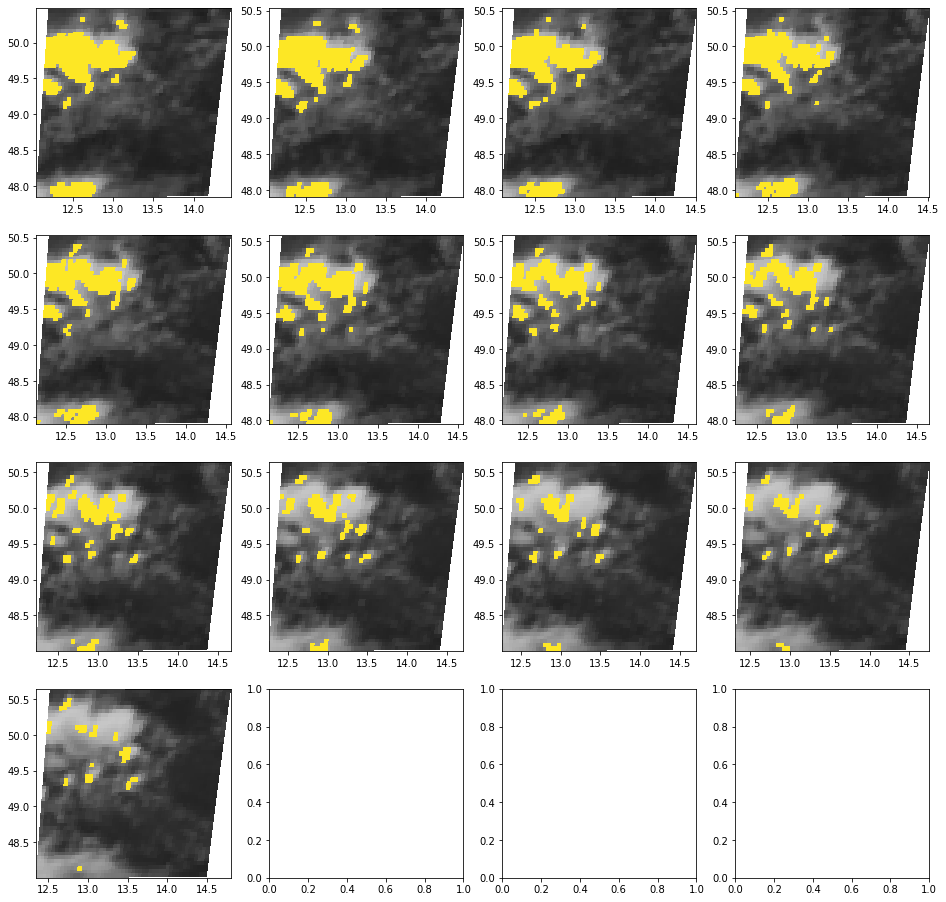

In [141]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i,m in enumerate(simpler_mask):
    #axs[i].imshow(track_data.vis006.data[i],vmin=0,vmax=1,cmap='gray')
    axs[i].pcolormesh(test_case.slon.data[i],
                      test_case.slat.data[i],
                      test_case.ir108.data[i],vmin=210,vmax=300,cmap='gray_r')
    axs[i].pcolormesh(test_case.slon.data[i],
                      test_case.slat.data[i],
                      np.ma.masked_where(m==False,m),vmin=0,vmax=0.4)
#     axs[i].pcolormesh(test_case.rlon.data[i],
#                       test_case.rlat.data[i],
#                       np.ma.masked_greater_equal(np.ma.masked_less(test_case.rx.data[i],5),92.5),
#                       vmin=5,vmax=65, cmap=rc())

Damit bekommt man auch recht passende Objekte, aber die Bereiche mit Eiswolken und unterkülten Wasserwolken werden nicht gut getrennt.